# Lesson 3 - Unknown Labels (Pets Revisited)


## Lesson Video:

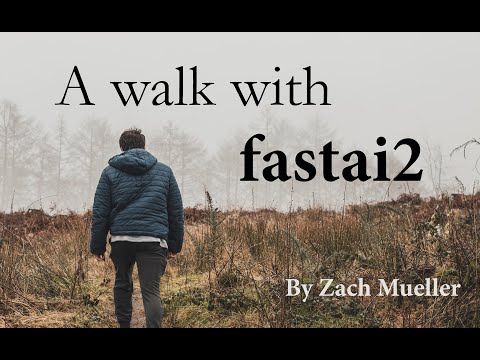

In [ ]:
#hide_input
from IPython.lib.display import YouTubeVideo
from datetime import timedelta
start = int(timedelta(minutes=31, seconds=43).total_seconds())
YouTubeVideo('pQ7CJzGn6YE', start=start)

In [ ]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.13 
* `wwf`: 0.0.5 
---

Imports:

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from functools import partial

from fastcore.transform import Pipeline

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, MultiCategoryBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, RegexLabeller, Normalize

from fastai.metrics import accuracy_multi, BCEWithLogitsLossFlat

from fastai.vision.augment import RandomResizedCrop, aug_transforms
from fastai.vision.core import get_image_files, PILImage
from fastai.vision.data import ImageBlock, imagenet_stats
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet34


In this notebook, we will use `MultiCategoryBlock` in a specially clever way to have our model return no labels when the given example does not belong to any of the classes seen during training. So let's repurpose our previous code for the dataset `pets` to be able to tell if an image does not belong to any of the breeds seen during training, e.g. a donkey picture. 

## Getting our Data

In [ ]:
path = untar_data(URLs.PETS)/'images'

In [ ]:
path.ls()[:3]

(#3) [Path('/root/.fastai/data/oxford-iiit-pet/images/pug_189.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_110.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_52.jpg')]

We'll go ahead and make the dataloaders with one important change, the get_y function since MutiCategoryBlock expects a list of labels. 

Now we pass that into our `get_y` along with any labeller

In [ ]:
pets_multi = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=Pipeline([RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'), lambda label: [label]]),
                 item_tfms=RandomResizedCrop(460, min_scale=0.75),
                 batch_tfms=[*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [ ]:
dls = pets_multi.dataloaders(untar_data(URLs.PETS)/"images",  bs=32)

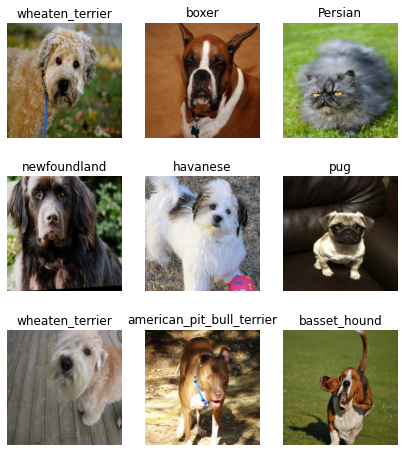

In [ ]:
dls.show_batch(max_n=9, figsize=(7,8))

## Training our Model

Note below a very important detail which is that there are two different thresholds. The metric will use a very high threshold so that only highly confident predictions are accepted as correct. The loss function, however, uses the default 0.5 threshold so that the model is not incentivated to make extreme predictions even if unsure.

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[partial(accuracy_multi, thresh=0.95)], loss_func=BCEWithLogitsLossFlat(thresh=0.5)).to_fp16()

In [ ]:
learn.fine_tune(epochs=4, base_lr=2e-3)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.405870,0.066770,0.973650,01:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.052957,0.023545,0.981312,01:14
1,0.025890,0.014233,0.989120,01:15
2,0.015388,0.010931,0.991790,01:15
3,0.010660,0.010087,0.992448,01:15


In [ ]:
learn.save('cats-vs-dogs')

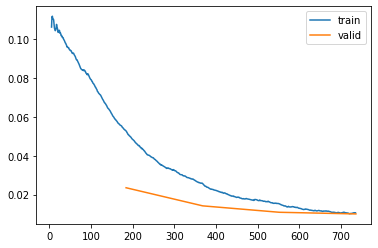

In [ ]:
learn.recorder.plot_loss()

That looks very nice..! Let's see how we did in the next section.

## Model evaluation

In [ ]:
learn.loss_func=BCEWithLogitsLossFlat(thresh=0.95)

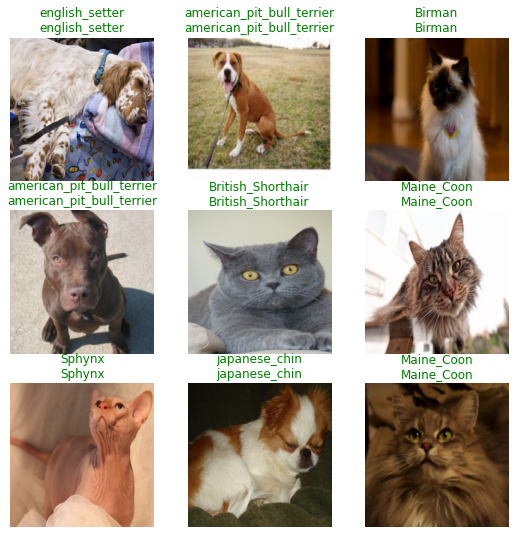

In [ ]:
learn.show_results()

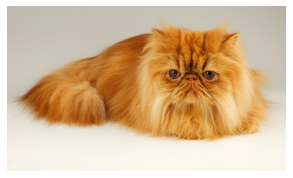

In [ ]:
img = PILImage.create('persian_cat.jpg')
img.show()

In [ ]:
learn.predict(img)[0]

(#1) ['Persian']

Awesome! The model returns only one label and it is the correct one. Let's see if we try with a donkey picture...

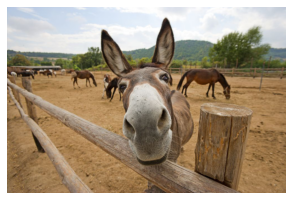

In [ ]:
img = PILImage.create('donkey.jpg')
img.show()

In [ ]:
learn.predict(img)[0]

(#0) []

Nothing! Our classifier is smart enough to return no label if the picture does not belong to any of the classes seen during training. Isn't it great?

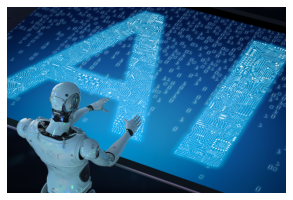

In [ ]:
img = PILImage.create('real-ai.jpg')
img.show()

In [ ]:
learn.predict(img)[0]

(#0) []